In [58]:
import gym

In [55]:
import numpy as np
from functools import partial
import copy

def move_left(current_position, states):
    reward=0
    current_index = states.index(current_position)
    if current_index==0:
        return "end", 0
    return states[current_index-1], reward
    
def move_right(current_position, states):
    current_index = states.index(current_position)
    if current_index==len(states)-1:
        return "end", 1
    else:
        return states[current_index+1],0

def run_episode(start, states, policy, actions):
    current_state=start
    history = []
    while current_state!="end":
        # pick an action
        action = policy(current_state, actions)
        new_state,reward = action(current_state, states) 
        history.append((current_state,action.__name__,reward))
        current_state = new_state
    return history


def compute_return(reawards_ahead, gamma):
    G = 0
    for t,r in enumerate(reawards_ahead):
        G += (gamma)**t * r
    return G


def mdp_policy_evaluation(states, actions, n_iter=10, gamma=0.9):
    V_old = [0]*len(states)
    for _ in range(n_iter):
        V_new = [0]*len(states)
        for i,s in enumerate(states):
            for a in actions:
                sprime , r = a(s,states)
                if sprime!="end":
                    Vsprime = V_old[states.index(sprime)]
                    Pa_ssprime = 1
                    V_new[i] += 0.5 * (r + gamma * Pa_ssprime * Vsprime)
                else:
                    V_new[i] += 0.5 * r
        V_old = V_new
    return np.array(V_new)


def mc_policy_eval(states, policy, n_iter=10, gamma=0.9, alpha=0.1):
    if not alpha:
        N = [0]*len(states)
    V = [0.5]*len(states)
    start = len(states)//2
    V_hist = []
    for e in range(n_iter):
        
        # start of episode
        history = run_episode(start, states, policy, actions)
        S = [s for s,a,r in history]
        R = [r for s,a,r in history]
        
        for t in range(len(history)):
            St = history[t][0]
            i_St = states.index(St)
            
            if not alpha:
                N[i_St] +=1

            # Compute Return from sthis state onwards
            G = compute_return(R[t:], gamma)

            # update value
            if not alpha:
                if N[i_St]>0:
                    V[i_St] += (1/(N[i_St]))*(G - V[i_St])
            else:
                V[i_St] += alpha*(G - V[i_St])
                  
        # end of episode
        V_hist.append(copy.copy(V))
    return V_hist


def td_policy_eval(states, policy, n_iter=10, gamma=0.9, alpha=0.1):
    V = [0.5]*len(states)
    start = len(states)//2
    V_hist = []
    for e in range(n_iter):
        
        # start of episode
        history = run_episode(start, states, policy, actions)
        for t in range(len(history)):
            St = history[t][0]
            i_St = states.index(St)
            Rt_1 = history[t][2]
            
            if t<len(history)-1:
                St_1 = history[t+1][0]
                i_St_1 = states.index(St_1)
                td_target = Rt_1 + gamma * V[i_St_1]
                V[i_St] += alpha*(td_target - V[i_St])
            else:
                V[i_St] += alpha*(Rt_1 - V[i_St])
        # end of episode    
        V_hist.append(copy.copy(V))
    return V_hist

def compute_rmse(V, V_mdp):
    squared_err=0
    for v,v_mdp in zip(V,V_mdp):
        squared_err+=(v-v_mdp)**2
    return np.sqrt(squared_err/len(V))


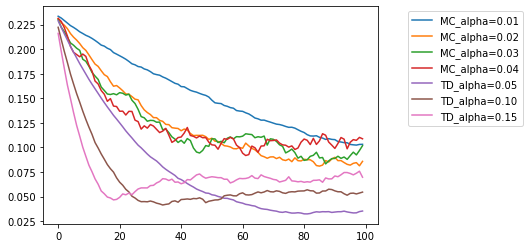

In [56]:
import matplotlib.pyplot as plt

states = list(range(5))
actions = [move_left, move_right]
start = len(states)//2

def random_policy(state, actions=actions):
    return np.random.choice(actions)

mdp_values = mdp_policy_evaluation(states, actions, n_iter=100, gamma=1)

f_err = lambda v : list(map(partial(compute_rmse,V_mdp=mdp_values),v))


mc_alphas = [.01,.02,.03,.04]
td_alphas = [.05,.1,.15]

err_mc_alpha = [[] for alpha in mc_alphas]
err_td_alpha = [[] for alpha in td_alphas]

nsamples = 50
n_iter = 100

for i, alpha in enumerate(mc_alphas):
    tmp = np.zeros((nsamples,n_iter))
    for k in range(nsamples):
        mc_values = mc_policy_eval(states, random_policy, n_iter=n_iter,gamma=1, alpha=alpha)
        tmp[k] = np.array(f_err(mc_values))
    err_mc_alpha[i] = np.average(tmp,axis=0)

for i, alpha in enumerate(td_alphas):
    tmp = np.zeros((nsamples,n_iter))
    for k in range(nsamples):
        td_values = td_policy_eval(states, random_policy, n_iter=n_iter,gamma=1, alpha=alpha)
        tmp[k] = np.array(f_err(td_values))
    err_td_alpha[i] = np.average(tmp,axis=0)

for i,alpha in enumerate(mc_alphas):
    plt.plot(err_mc_alpha[i],label="MC_alpha=%.2f"%alpha)
for i,alpha in enumerate(td_alphas):
    plt.plot(err_td_alpha[i],label="TD_alpha=%.2f"%alpha)
plt.legend(bbox_to_anchor=(1.45, 1),loc='upper right')
plt.show()

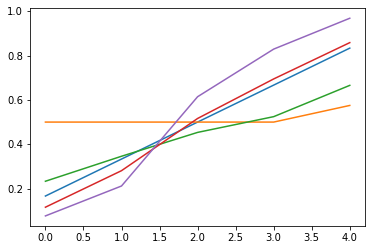

In [57]:
plt.plot(mdp_values)
# plt.plot(mc_values[-1])
for i in [1,10,100,200]:
    plt.plot(td_policy_eval(states, random_policy, n_iter=i,gamma=1, alpha=.15)[-1])
plt.show()